# Nitrogen nutritional index

Soil chemical properties based on LUCAS topsoil data (Ballabio et al., 2019;
European Commission, n.d.; Panagos et al., 2022; Panagos et al., 2012):
https://esdac.jrc.ec.europa.eu/content/chemical-properties-european-scale-based-lucas-topsoil-data

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
from rasterstats import zonal_stats

In [2]:
DATA_DIR = os.path.join(
    "data", "soil",
    "chemical-properties-european-scale-based-lucas-topsoil-data"
)

In [3]:
DATA_FILE = os.path.join(DATA_DIR, "IE_N.tif")

In [4]:
data = rxr.open_rasterio(DATA_FILE, chunks="auto", masked=True)

In [5]:
data

<xarray.DataArray (band: 1, y: 818, x: 835)>
dask.array<open_rasterio-fc87d89a5ce8db95ff48491a55ae131c<this-array>, shape=(1, 818, 835), dtype=float32, chunksize=(1, 818, 835), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.918e+06 2.919e+06 ... 3.335e+06 3.335e+06
  * y            (y) float64 3.728e+06 3.728e+06 3.727e+06 ... 3.32e+06 3.32e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  0.9927304438511346
    STATISTICS_MAXIMUM:      15.40726184845
    STATISTICS_MEAN:         2.1118209123088
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       0.99635859199945
    scale_factor:            1.0
    add_offset:              0.0

In [6]:
data.rio.crs

CRS.from_epsg(3035)

In [7]:
data.rio.resolution()

(500.0, -500.0)

In [8]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")

In [9]:
ie.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
data.max().values

array(9.951199, dtype=float32)

In [11]:
data.min().values

array(1.2719605, dtype=float32)

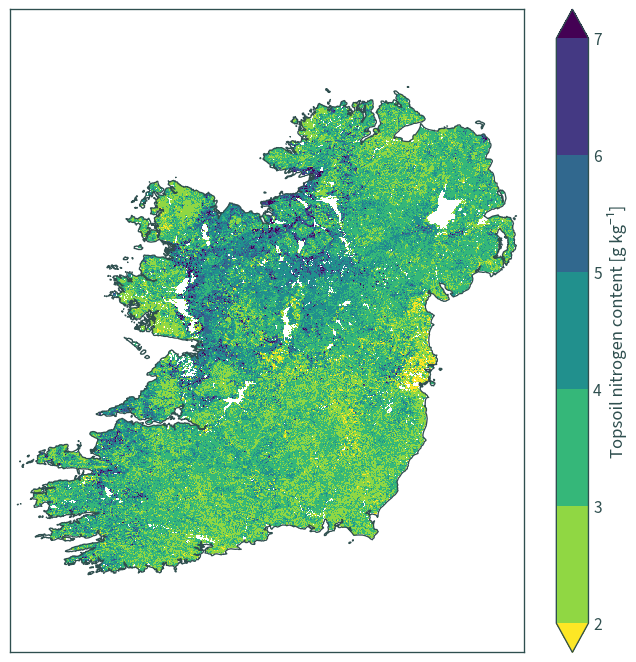

In [12]:
fig = data.plot(
    robust=True, cmap="viridis_r", figsize=(7, 7), levels=6,
    cbar_kwargs={"label": "Topsoil nitrogen content [g kg⁻¹]"}
)
ie.to_crs(data.rio.crs).boundary.plot(
    ax=fig.axes, color="darkslategrey", linewidth=1
)
plt.title(None)
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.axis("equal")
plt.show()

## Grid cells

In [13]:
grid_cells = gpd.read_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="hiresireland"
)

In [14]:
grid_cells.head()

,rlon,rlat,sr,geometry
0,-1.680,-1.315,0.917024,"POLYGON ((417558.169 590305.235, 417549.771 59..."
1,-1.680,-1.280,0.917024,"POLYGON ((417549.771 594200.519, 417541.440 59..."
2,-1.645,-1.595,0.763591,"POLYGON ((421531.348 559152.004, 421522.478 56..."
3,-1.645,-1.315,0.917024,"POLYGON ((421462.259 590312.894, 421453.924 59..."
4,-1.645,-1.280,0.917024,"POLYGON ((421453.924 594208.112, 421445.655 59..."


In [15]:
grid_cells.crs

<Derived Projected CRS: EPSG:2157>
Name: IRENET95 / Irish Transverse Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore. United Kingdom (UK) - Northern Ireland (Ulster) - onshore.
- bounds: (-10.56, 51.39, -5.34, 55.43)
Coordinate Operation:
- name: Irish Transverse Mercator
- method: Transverse Mercator
Datum: IRENET95
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
grid_cells.shape

(6118, 4)

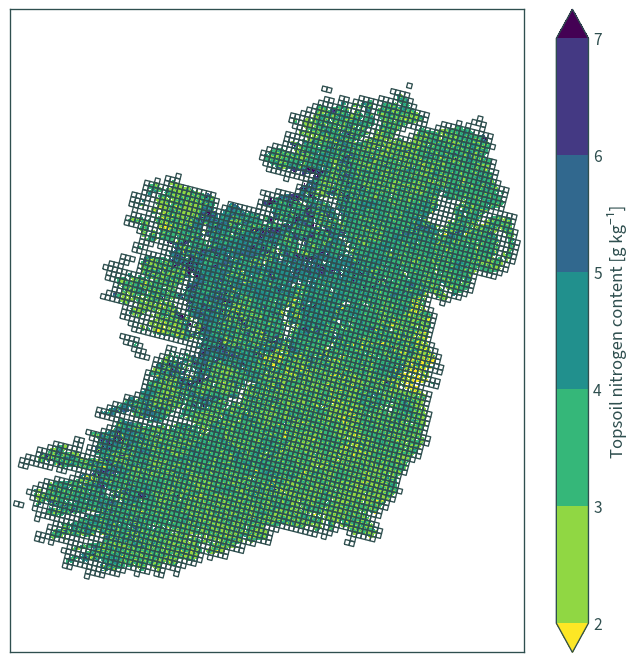

In [17]:
fig = data.plot(
    robust=True, cmap="viridis_r", figsize=(7, 7), levels=6,
    cbar_kwargs={"label": "Topsoil nitrogen content [g kg⁻¹]"}
)
grid_cells.to_crs(data.rio.crs).boundary.plot(
    ax=fig.axes, color="darkslategrey", linewidth=1
)
plt.title(None)
fig.axes.tick_params(labelbottom=False, labelleft=False)
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.axis("equal")
plt.show()

## Zonal stats

In [18]:
grid_cells = gpd.GeoDataFrame.from_features(
    zonal_stats(
        vectors=grid_cells.to_crs(data.rio.crs),
        raster=os.path.join(DATA_DIR, "IE_N.tif"),
        stats=["count", "mean"],
        geojson_out=True
    ), crs=data.rio.crs
).to_crs(grid_cells.crs)

In [19]:
grid_cells.head()

,geometry,rlon,rlat,sr,count,mean
0,"POLYGON ((417558.169 590305.235, 417549.771 59...",-1.680,-1.315,0.917024,0,NaN
1,"POLYGON ((417549.771 594200.519, 417541.440 59...",-1.680,-1.280,0.917024,0,NaN
2,"POLYGON ((421531.348 559152.004, 421522.478 56...",-1.645,-1.595,0.763591,0,NaN
3,"POLYGON ((421462.259 590312.894, 421453.924 59...",-1.645,-1.315,0.917024,0,NaN
4,"POLYGON ((421453.924 594208.111, 421445.655 59...",-1.645,-1.280,0.917024,0,NaN


In [20]:
grid_cells.shape

(6118, 6)

In [21]:
grid_cells["mean"].min()

1.761827422351372

In [22]:
grid_cells["mean"].max()

7.460216946072048

In [23]:
grid_cells["count"].min()

0

In [24]:
grid_cells["count"].max()

64

In [25]:
grid_cells[grid_cells["count"] == 0]

,geometry,rlon,rlat,sr,count,mean
0,"POLYGON ((417558.169 590305.235, 417549.771 59...",-1.680,-1.315,0.917024,0,NaN
1,"POLYGON ((417549.771 594200.519, 417541.440 59...",-1.680,-1.280,0.917024,0,NaN
2,"POLYGON ((421531.348 559152.004, 421522.478 56...",-1.645,-1.595,0.763591,0,NaN
3,"POLYGON ((421462.259 590312.894, 421453.924 59...",-1.645,-1.315,0.917024,0,NaN
4,"POLYGON ((421453.924 594208.111, 421445.655 59...",-1.645,-1.280,0.917024,0,NaN
...,...,...,...,...,...,...
6103,"POLYGON ((756735.711 882973.333, 756728.348 88...",1.365,1.310,2.021384,0,NaN
6104,"POLYGON ((760717.627 840119.590, 760710.879 84...",1.400,0.925,2.126344,0,NaN
6113,"POLYGON ((764608.869 847919.894, 764601.966 85...",1.435,0.995,2.685055,0,NaN
6114,"POLYGON ((764601.966 851816.404, 764595.002 85...",1.435,1.030,2.685055,0,NaN


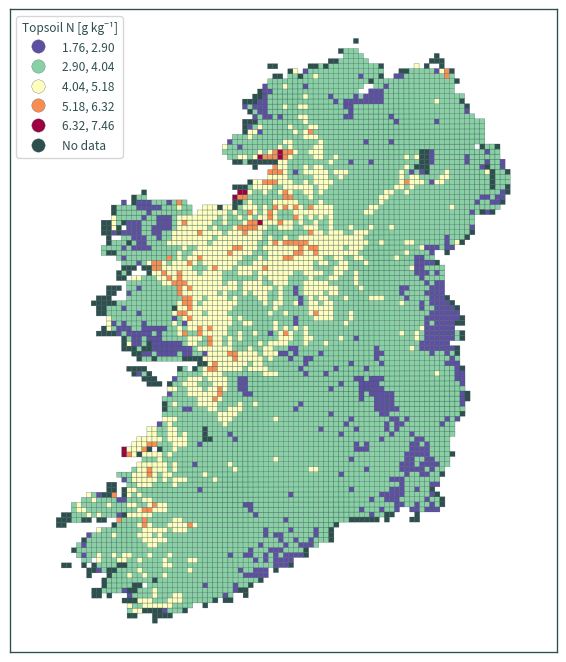

In [26]:
axs = grid_cells.plot(
    column="mean", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}", "title": "Topsoil N [g kg⁻¹]"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

## Normalise

In [27]:
# normalise between 1.0 and 0.35
grid_cells["ni"] = (
    0.35 + (
        (grid_cells["mean"] - float(grid_cells["mean"].min())) * (1.0 - 0.35)
    ) / (
        float(grid_cells["mean"].max()) - float(grid_cells["mean"].min())
    )
)

In [28]:
grid_cells.head()

,geometry,rlon,rlat,sr,count,mean,ni
0,"POLYGON ((417558.169 590305.235, 417549.771 59...",-1.680,-1.315,0.917024,0,NaN,NaN
1,"POLYGON ((417549.771 594200.519, 417541.440 59...",-1.680,-1.280,0.917024,0,NaN,NaN
2,"POLYGON ((421531.348 559152.004, 421522.478 56...",-1.645,-1.595,0.763591,0,NaN,NaN
3,"POLYGON ((421462.259 590312.894, 421453.924 59...",-1.645,-1.315,0.917024,0,NaN,NaN
4,"POLYGON ((421453.924 594208.111, 421445.655 59...",-1.645,-1.280,0.917024,0,NaN,NaN


In [29]:
grid_cells["ni"].max()

1.0

In [30]:
grid_cells["ni"].min()

0.35

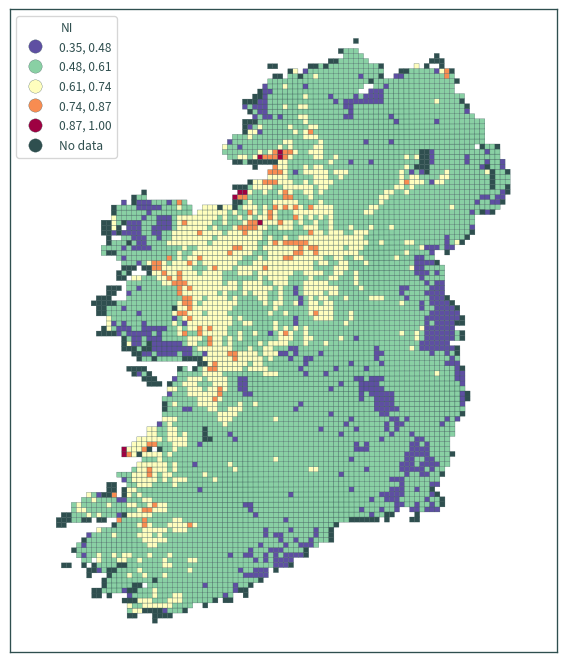

In [31]:
axs = grid_cells.plot(
    column="ni", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}", "title": "NI"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [32]:
# fill no data with min value
grid_cells["ni"] = grid_cells["ni"].fillna(grid_cells["ni"].min())

In [34]:
grid_cells.head()

,geometry,rlon,rlat,sr,count,mean,ni
0,"POLYGON ((417558.169 590305.235, 417549.771 59...",-1.680,-1.315,0.917024,0,NaN,0.35
1,"POLYGON ((417549.771 594200.519, 417541.440 59...",-1.680,-1.280,0.917024,0,NaN,0.35
2,"POLYGON ((421531.348 559152.004, 421522.478 56...",-1.645,-1.595,0.763591,0,NaN,0.35
3,"POLYGON ((421462.259 590312.894, 421453.924 59...",-1.645,-1.315,0.917024,0,NaN,0.35
4,"POLYGON ((421453.924 594208.111, 421445.655 59...",-1.645,-1.280,0.917024,0,NaN,0.35


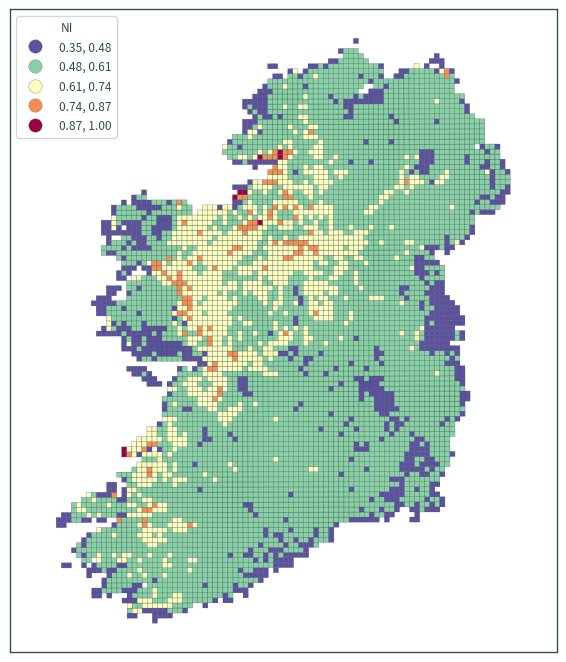

In [33]:
axs = grid_cells.plot(
    column="ni", cmap="Spectral_r", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}", "title": "NI"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

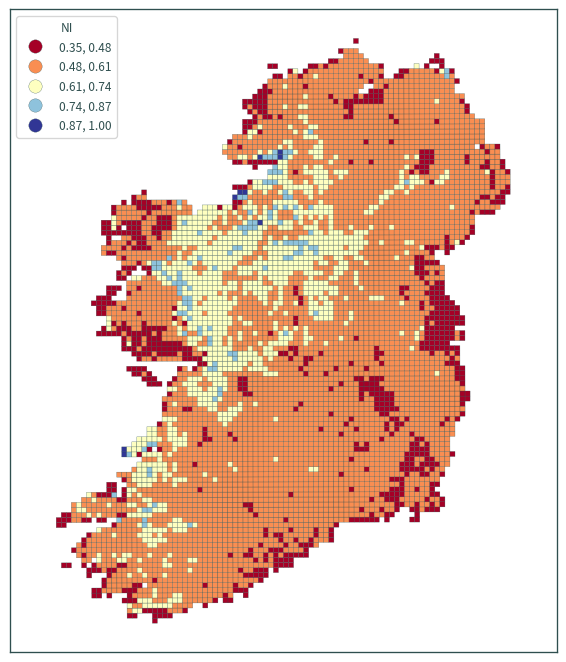

In [4]:
axs = grid_cells.plot(
    column="ni", cmap="RdYlBu", scheme="equal_interval",
    edgecolor="darkslategrey", linewidth=.2, figsize=(6, 7),
    legend=True, legend_kwds={
        "loc": "upper left", "fmt": "{:.2f}", "title": "NI"
    },
    missing_kwds={
        "color": "darkslategrey", "edgecolor": "darkslategrey",
        "label": "No data"
    }
)
for legend_handle in axs.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(.2)
    legend_handle.set_markeredgecolor("darkslategrey")
axs.tick_params(labelbottom=False, labelleft=False)
plt.axis("equal")
plt.tight_layout()
plt.show()

In [35]:
grid_cells.drop(columns=["mean", "count"], inplace=True)

In [36]:
grid_cells.to_file(
    os.path.join("data", "ModVege", "params.gpkg"), layer="hiresireland"
)